# Using Long Simulations instead of Accelerated Simulations

In [23]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
from stopit import threading_timeoutable as timeoutable


eSOH_DIR = "./data/esoh_V/"
oCV_DIR = "./data/ocv/"
fig_DIR = "./figures/figures_sens/"
res_DIR = "./data/results_sens/"

In [24]:
plt.rcParams["lines.markersize"] = 5
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams["font.size"] = 12
plt.rcParams["legend.fontsize"] = 10
plt.rcParams["legend.frameon"] = False
plt.rcParams["font.family"] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['mathtext.it'] = 'serif:italic'
plt.rcParams['mathtext.bf'] = 'serif:bold'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.axisbelow"] = True
plt.rcParams["grid.linestyle"] = "--"
plt.rcParams["grid.color"] = (0.8, 0.8, 0.8)
plt.rcParams["grid.alpha"] = 0.5
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 600
plt.rcParams['figure.max_open_warning']=False

In [25]:
def nmc_volume_change_mohtat(sto,c_s_max):
    t_change = -1.10/100*(1-sto)
    return t_change

def graphite_volume_change_mohtat(sto,c_s_max):
    stoichpoints = np.array([0,0.12,0.18,0.24,0.50,1])
    thicknesspoints = np.array([0,2.406/100,3.3568/100,4.3668/100,5.583/100,13.0635/100])
    x = [sto]
    t_change = pybamm.Interpolant(stoichpoints, thicknesspoints, x, name=None, interpolator='linear', extrapolate=True, entries_string=None)
    return t_change

def get_parameter_values():
    parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Mohtat2020)
    parameter_values.update(
        {
            # mechanical properties
            "Positive electrode Poisson's ratio": 0.3,
            "Positive electrode Young's modulus [Pa]": 375e9,
            "Positive electrode reference concentration for free of deformation [mol.m-3]": 0,
            "Positive electrode partial molar volume [m3.mol-1]": -7.28e-7,
            "Positive electrode volume change": nmc_volume_change_mohtat,
            # Loss of active materials (LAM) model
            "Positive electrode LAM constant exponential term": 2,
            "Positive electrode critical stress [Pa]": 375e6,
            # mechanical properties
            "Negative electrode Poisson's ratio": 0.2,
            "Negative electrode Young's modulus [Pa]": 15e9,
            "Negative electrode reference concentration for free of deformation [mol.m-3]": 0,
            "Negative electrode partial molar volume [m3.mol-1]": 3.1e-6,
            "Negative electrode volume change": graphite_volume_change_mohtat,
            # Loss of active materials (LAM) model
            "Negative electrode LAM constant exponential term": 2,
            "Negative electrode critical stress [Pa]": 60e6,
            # Other
            "Cell thermal expansion coefficient [m.K-1]": 1.48E-6,
            "Lower voltage cut-off [V]": 3.0
        },
        check_already_exists=False,
    )
    return parameter_values
parameter_values = get_parameter_values()

In [26]:
def split_long_string(title, max_words=None):
    """Get title in a nice format"""
    max_words = max_words or pybamm.settings.max_words_in_line
    words = title.split()
    # Don't split if fits on one line, don't split just for units
    if len(words) <= max_words or words[max_words].startswith("["):
        return title
    else:
        first_line = (" ").join(words[:max_words])
        second_line = (" ").join(words[max_words:])
        return first_line + "\n" + second_line

In [27]:
def plot(all_sumvars_dict,esoh_data):
    esoh_vars = ["x_0", "y_0", "x_100", "y_100", "C_n", "C_p"]
    # esoh_vars = ["Capacity [A.h]", "Loss of lithium inventory [%]",
    #              "Loss of active material in negative electrode [%]",
    #              "Loss of active material in positive electrode [%]"]
    fig, axes = plt.subplots(3,2,figsize=(7,7))
    for k, name in enumerate(esoh_vars):
        ax = axes.flat[k]
        ax.plot(all_sumvars_dict["Cycle number"],all_sumvars_dict[name],"ro")
        ax.plot(esoh_data["N"],esoh_data[name],"kx")
#         ax.scatter(all_sumvars_dict["Cycle number"],all_sumvars_dict[name],color="r")
    #     ax.plot(long_sol.summary_variables[name],"b-")
        ax.set_title(split_long_string(name))
        if k>3:
            ax.set_xlabel("Cycle number")
    # fig.subplots_adjust(bottom=0.4)
    fig.legend(["Acc Sim"] + ["Reported"], 
           loc="lower center", ncol=1, fontsize=11)
    fig.tight_layout()
    return fig

def plot1(all_sumvars_dict,esoh_data):
    esoh_vars = ["Capacity [A.h]","n_Li"]
    esoh_data["Capacity [A.h]"]=esoh_data["Cap"]
    param = pybamm.LithiumIonParameters()
    esoh_data["n_Li"]= 3600/param.F.value*(esoh_data["y_100"]*esoh_data["C_p"]+esoh_data["x_100"]*esoh_data["C_n"])
    fig, axes = plt.subplots(2,1,figsize=(7,7))
    for k, name in enumerate(esoh_vars):
        ax = axes.flat[k]
        ax.plot(all_sumvars_dict["Cycle number"],all_sumvars_dict[name],"ro")
        ax.plot(esoh_data["N"],esoh_data[name],"kx")
        ax.set_title(split_long_string(name))
        ax.set_xlabel("Cycle number")
    fig.legend(["Acc Sim"] + ["Reported"], 
           loc="upper right", ncol=1, fontsize=11)
    fig.tight_layout()
    return fig
def plotc(all_sumvars_dict,esoh_data):
    esoh_vars = ["x_100", "y_0", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]"]
    esoh_data["Capacity [A.h]"]=esoh_data["Cap"]
    param = pybamm.LithiumIonParameters()
    esoh_data["n_Li"]= 3600/param.F.value*(esoh_data["y_100"]*esoh_data["C_p"]+esoh_data["x_100"]*esoh_data["C_n"])
    esoh_data["Loss of lithium inventory [%]"]=(1-esoh_data["n_Li"]/esoh_data["n_Li"][0])*100
    fig, axes = plt.subplots(3,2,figsize=(7,7))
    for k, name in enumerate(esoh_vars):
        ax = axes.flat[k]
        ax.plot(all_sumvars_dict["Cycle number"],all_sumvars_dict[name],"ro")
        ax.plot(esoh_data["N"],esoh_data[name],"kx")
        ax.set_title(split_long_string(name))
        if k ==2 or k==3:
            ax.set_ylim([3,6.2])
        if k>3:
            ax.set_xlabel("Cycle number")
    fig.legend(["Acc Sim"] + ["Reported"], 
           loc="lower center",bbox_to_anchor=[0.5,-0.02], ncol=1, fontsize=11)
    fig.tight_layout()
    return fig

def plotcomp(all_sumvars_dict0,all_sumvars_dict1):
    esoh_vars = ["x_100", "y_0", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]"]
    fig, axes = plt.subplots(3,2,figsize=(7,7))
    for k, name in enumerate(esoh_vars):
        ax = axes.flat[k]
        ax.plot(all_sumvars_dict0["Cycle number"],all_sumvars_dict0[name],"k.")
        ax.plot(all_sumvars_dict1["Cycle number"],all_sumvars_dict1[name],"b.")
        ax.set_title(split_long_string(name))
        if k ==2 or k==3:
            ax.set_ylim([3,6.2])
        if k>3:
            ax.set_xlabel("Cycle number")
    fig.legend(["Baseline"] + ["Sim"], 
           loc="lower center",bbox_to_anchor=[0.5,-0.02], ncol=1, fontsize=11)
    fig.tight_layout()
    return fig

def plotcomplong(all_sumvars_dict0,all_sumvars_dict1,all_sumvars_dict2):
    esoh_vars = ["x_100", "y_0", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]"]
    fig, axes = plt.subplots(3,2,figsize=(7,7))
    for k, name in enumerate(esoh_vars):
        ax = axes.flat[k]
        ax.plot(all_sumvars_dict0["Cycle number"],all_sumvars_dict0[name],"kx")
        ax.plot(all_sumvars_dict1["Cycle number"],all_sumvars_dict1[name],"bo")
        ax.plot(all_sumvars_dict2["Cycle number"],all_sumvars_dict2[name],"m.")
        ax.set_title(split_long_string(name))
        if k ==2 or k==3:
            ax.set_ylim([3,6.2])
        if k>3:
            ax.set_xlabel("Cycle number")
    fig.legend(["Baseline"] + ["Accl Sim"] + ["Long Sim"], 
            loc="lower center",bbox_to_anchor=[0.5,-0.02], ncol=1, fontsize=11)
    fig.tight_layout()
    return fig

In [28]:
cell = 22
# cell = 23

In [29]:
def load_data(cell): 
    cell_no = f'{cell:02d}'
    dfe=pd.read_csv(eSOH_DIR+"aging_param_cell_"+cell_no+".csv")
    dfe_0=pd.read_csv(eSOH_DIR+"aging_param_cell_"+cell_no+".csv")
    # dfo_0=pd.read_csv(oCV_DIR+"ocv_data_cell_"+cell_no+".csv")
    # if cell_no=='13':
    #     dfo_d=dfo_0[dfo_0['N']==dfe['N'].iloc[-5]]
    #     dfo_0=dfo_0.drop(dfo_d.index.values)
    #     dfo_0=dfo_0.reset_index(drop=True)
    #     dfe = dfe.drop(dfe.index[-5])
    #     dfe = dfe.reset_index(drop=True)
    # Remove first RPT
    # dfe = dfe.drop(dfe.index[0])
    # dfe = dfe.reset_index(drop=True)
    # dfo_d=dfo_0[dfo_0['N']==0]
    # dfo_0=dfo_0.drop(dfo_d.index.values)
    # if cell_no=='13':
    #     dfe = dfe.drop(dfe.index[-1])
    #     dfe = dfe.reset_index(drop=True)
    #     dfe_0 = dfe_0.drop(dfe_0.index[-1])
    #     dfe_0 = dfe_0.reset_index(drop=True)
    # dfe['N']=dfe['N']-dfe['N'][0]
    dfe['N']=dfe['Time']
    N =dfe.N.unique()

    print("Cycle Numbers:")
    print(*N, sep = ", ") 
    # print(len(N_0))
    # print(len(dfo_0))
    # rev_exp = []
    # irrev_exp = []

    return cell_no,dfe,N

In [30]:
cell_no,dfe,N = load_data(cell)

Cycle Numbers:
0.0, 25.2705671642907, 93.0685096180532, 130.029355057864, 168.119850242976, 204.058473101817, 245.030302534695


In [31]:
def init_exp(cell_no,dfe):
    # dfe_0 = dfe[dfe['N']==N[0]]
    C_n_init = dfe['C_n'][0]
    C_p_init = dfe['C_p'][0]
    y_0_init = dfe['y_0'][0] 
    if cell_no=='22':
        SOC_0 = 1
    #     x_init = esoh_sol["x_100"].data[0] 
    #     y_init = esoh_sol["y_100"].data[0] 
    elif cell_no=='23':
        SOC_0 = 0.5
    #     x_init = 0.5*(esoh_sol["x_100"].data[0]-esoh_sol["x_0"].data[0])
    #     y_init = 0.5*(esoh_sol["y_0"].data[0]-esoh_sol["y_100"].data[0])

    return C_n_init,C_p_init,SOC_0#,x_init,y_init,c_rate_c,c_rate_d,dis_set

In [32]:
# C_n_init,C_p_init,x_init,y_init,c_rate_c,c_rate_d,dis_set = init_exp(cell_no,dfe)
C_n_init,C_p_init,SOC_0 = init_exp(cell_no,dfe)

In [33]:
pybamm.set_logging_level("WARNING")
# pybamm.set_logging_level("NOTICE")
calendar_time = 24
experiment = pybamm.Experiment(
    [
        ("Rest for "+f'{calendar_time}'+" hours",)
    ]*250 ,
    termination="50% capacity",
#     cccv_handling="ode",
)
spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        # "loss of active material": ("stress-driven","none"),
        "loss of active material": "stress-driven",
        # "stress-induced diffusion": "true",
        # "lithium plating": "reversible",
    }
)
# spm.print_parameter_info()

In [34]:
param = spm.param
eps_n_data = parameter_values.evaluate(C_n_init*3600/(param.n.L * param.n.c_max * param.F* param.A_cc))
eps_p_data = parameter_values.evaluate(C_p_init*3600/(param.p.L * param.p.c_max * param.F* param.A_cc))
# cs_p_init = parameter_values.evaluate(y_0_init* param.c_p_max)

In [35]:
Temp = [25,45,-5]
k_sei = [1,1/1.5,1.5,1/2,2,1/3,3,1/10,10]
# d_sei = [1,1/1.5,1.5,1/2,2,1/3,3,1/10,100]
d_sei = [1,1e-1,1e1,1e-2,1e2,1e-3,1e3,1e-4,1e4]


In [36]:
ksei_idx = 0
dsei_idx = 0
Temp_idx = 0

In [37]:
parameter_values = get_parameter_values()

parameter_values.update(
    {
        "SEI kinetic rate constant [m.s-1]": 1.6827e-16*k_sei[ksei_idx], #1.6827e-16
        # "Positive electrode LAM constant proportional term [s-1]": 4.20e-06, #4.03536e-06
        # "Negative electrode LAM constant proportional term [s-1]": 5.38e-05, #5.24755e-05
        "Positive electrode LAM constant proportional term [s-1]": 5e-3/3600,
        "Negative electrode LAM constant proportional term [s-1]": 4.3e-2/3600,
        "EC diffusivity [m2.s-1]": 2e-18*d_sei[dsei_idx],
        "Positive electrode LAM constant exponential term": 2,
        "Negative electrode LAM constant exponential term": 2,
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        # "Initial concentration in positive electrode [mol.m-3]": y_init*c_p_max,
        # "Initial concentration in negative electrode [mol.m-3]": x_init*c_n_max,
        "Initial temperature [K]": 273.15+Temp[Temp_idx],
        "Ambient temperature [K]": 273.15+Temp[Temp_idx],
    },
    check_already_exists=False,
)

In [38]:
sim_long = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_long = sim_long.solve(initial_soc=1)
long_sol_output =sol_long.summary_variables
df = pd.DataFrame.from_dict(long_sol_output)
df.to_csv(res_DIR+'sens_long_T_{0}_k_{1}_D_{2}'.format(str(Temp_idx),str(ksei_idx),str(dsei_idx))+'.csv')

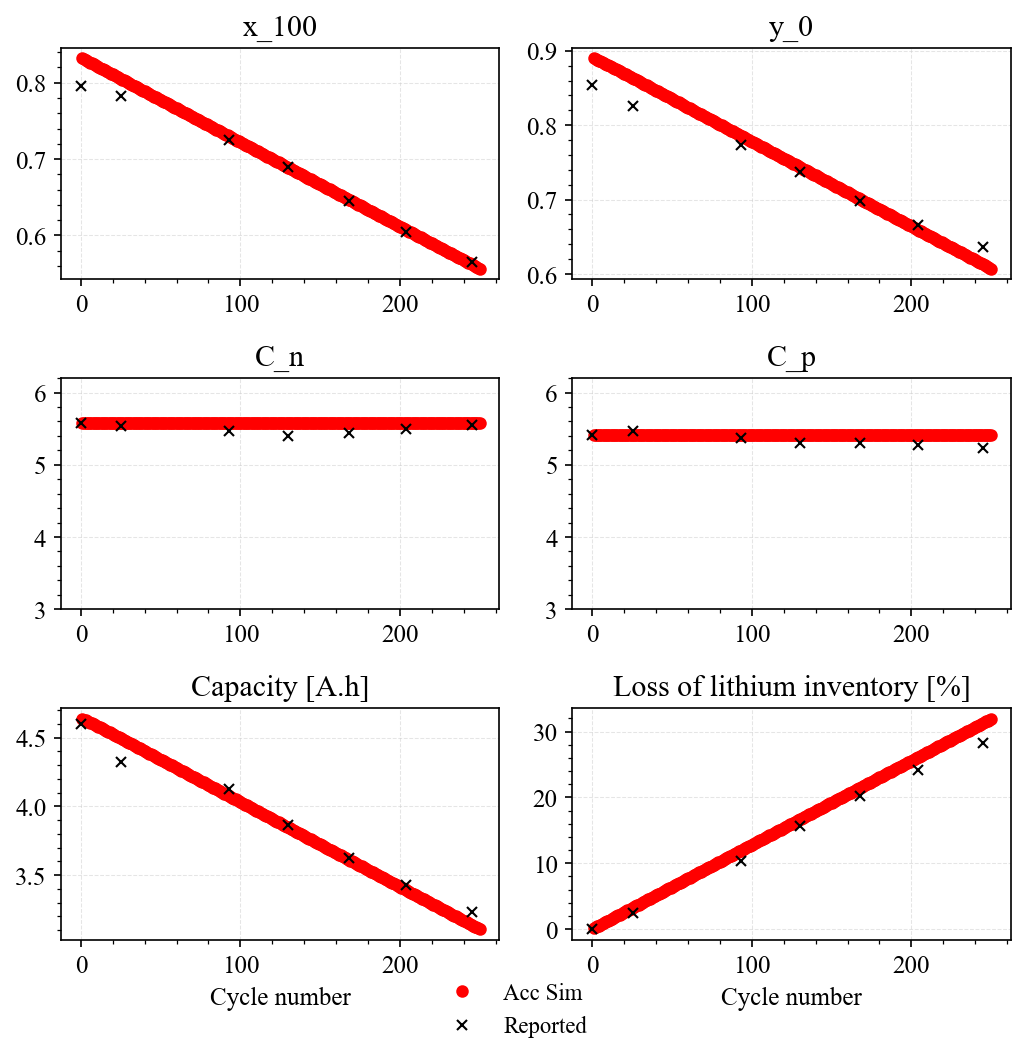

In [39]:
fig = plotc(long_sol_output,dfe);
# plt.savefig(fig_DIR +'calendar_aging_cell_'+cell_no+'_eSOH.png')

In [40]:
len(k_sei)

9

In [41]:
def sens_sim(ksei_idx=0,dsei_idx=0,Temp_idx=0):
    parameter_values.update(
        {
            "SEI kinetic rate constant [m.s-1]": 1.6827e-16*k_sei[ksei_idx], #1.6827e-16
            # "Positive electrode LAM constant proportional term [s-1]": 4.20e-06, #4.03536e-06
            # "Negative electrode LAM constant proportional term [s-1]": 5.38e-05, #5.24755e-05
            "Positive electrode LAM constant proportional term [s-1]": 5e-3/3600,
            "Negative electrode LAM constant proportional term [s-1]": 4.3e-2/3600,
            "EC diffusivity [m2.s-1]": 2e-18*d_sei[dsei_idx],
            "Positive electrode LAM constant exponential term": 2,
            "Negative electrode LAM constant exponential term": 2,
            "Negative electrode active material volume fraction": eps_n_data,
            "Positive electrode active material volume fraction": eps_p_data,
            # "Initial concentration in positive electrode [mol.m-3]": y_init*c_p_max,
            # "Initial concentration in negative electrode [mol.m-3]": x_init*c_n_max,
            "Initial temperature [K]": 273.15+Temp[Temp_idx],
            "Ambient temperature [K]": 273.15+Temp[Temp_idx],
        },
        check_already_exists=False,
    )
    sim_long = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
    sol_long = sim_long.solve(initial_soc=1)
    long_sol_output_1 =sol_long.summary_variables
    df_1 = pd.DataFrame.from_dict(long_sol_output_1)
    fig = plotcomp(long_sol_output,long_sol_output_1);
    plt.savefig(fig_DIR+'sens_long_T_{0}_k_{1}_D_{2}'.format(str(Temp_idx),str(ksei_idx),str(dsei_idx))+'_eSOH.png');
    df_1 = pd.DataFrame.from_dict(long_sol_output_1)
    df_1.to_csv(res_DIR+'sens_long_T_{0}_k_{1}_D_{2}'.format(str(Temp_idx),str(ksei_idx),str(dsei_idx))+'.csv')
    ## Long Sims
    # sim_long = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
    #                         solver=pybamm.CasadiSolver("safe"))
    # sol_long = sim_long.solve(initial_soc=1)
    # long_sol_output =sol_long.summary_variables
    # df_l = pd.DataFrame.from_dict(long_sol_output)
    # df_1.to_csv(res_DIR+'sens_long_T_{0}_k_{1}_D_{2}'.format(str(Temp_idx),str(ksei_idx),str(dsei_idx))+'.csv')
    # fig = plotcomplong(all_sumvars_dict,all_sumvars_dict_1,long_sol_output);
    # plt.savefig(fig_DIR+'sens_long_T_{0}_k_{1}_D_{2}'.format(str(Temp_idx),str(ksei_idx),str(dsei_idx))+'_eSOH.png')

ksei=0
dsei=0
temp=1
temp=2


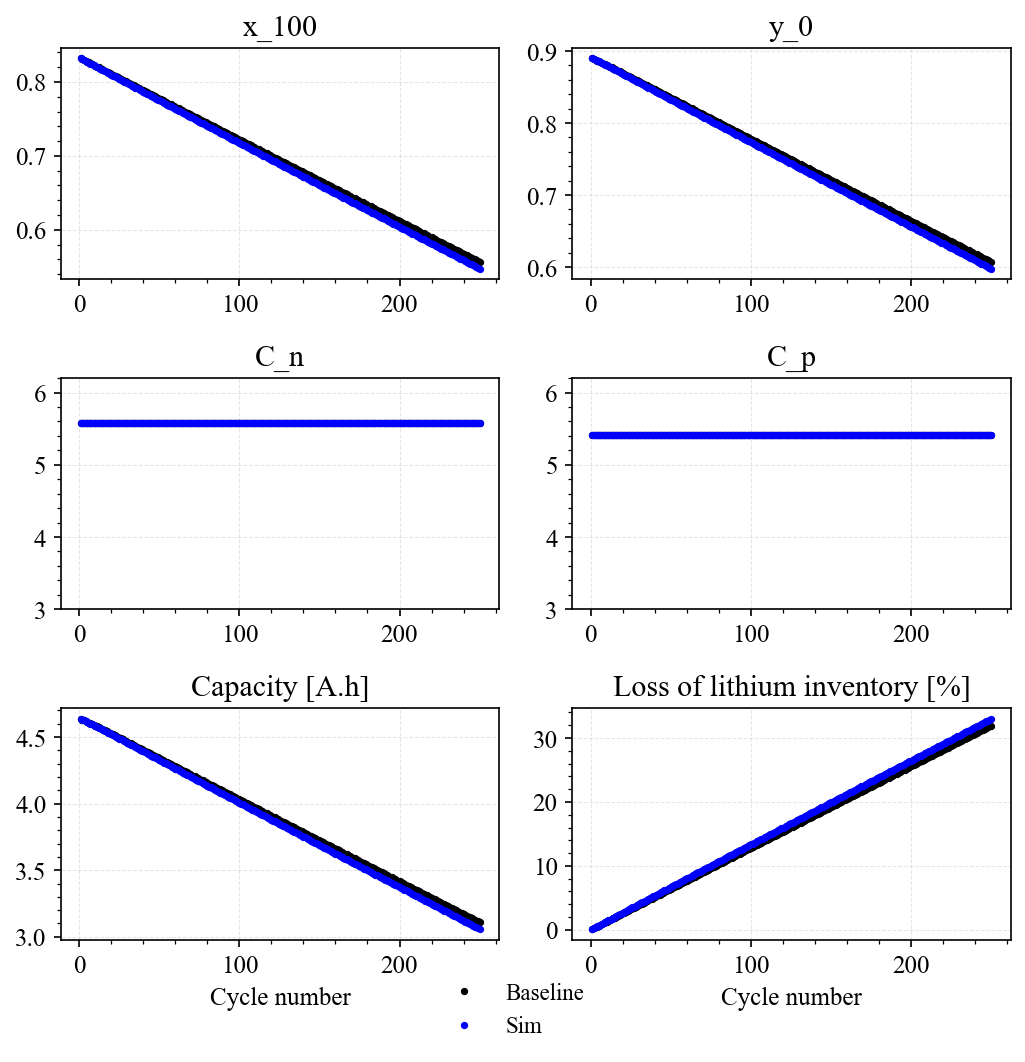

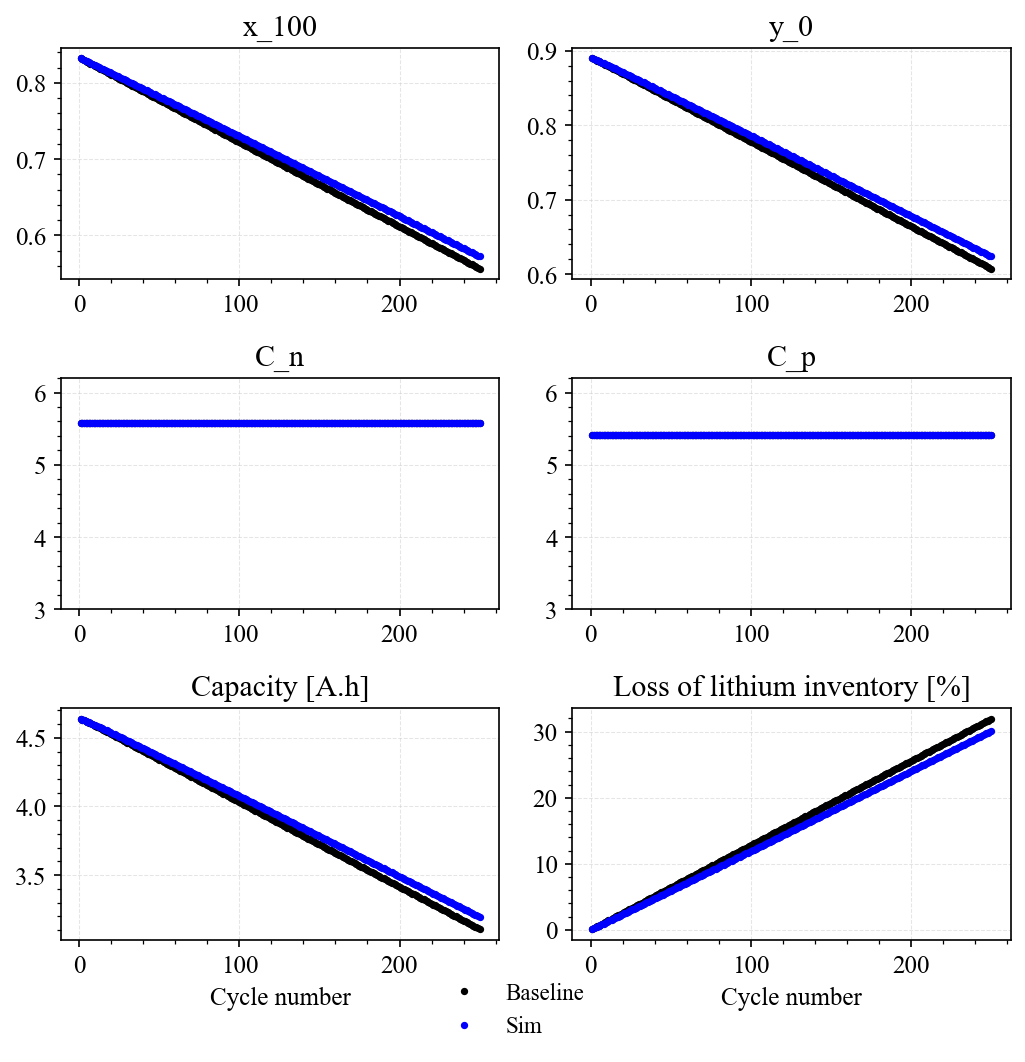

In [42]:
ii = 0
for kk in range(1):
    print('ksei='+str(kk))
    # sens_sim(ksei_idx=kk)
    # sens_sim(dsei_idx=kk)
    for dd in range(1):
        print('dsei='+str(dd))
        for tt in range(1,3):
            print('temp='+str(tt))
            sens_sim(ksei_idx=kk,dsei_idx=dd,Temp_idx=tt)
            ii+=1


In [43]:
dasdas

NameError: name 'dasdas' is not defined

In [ ]:
calendar_time = 24
experiment = pybamm.Experiment(
    [
        ("Rest for "+f'{calendar_time}'+" hours",)
    ]*1,
    termination="50% capacity",
#     cccv_handling="ode",
)

In [ ]:
ksei_idx = 0
dsei_idx = 0
Temp_idx = 0

In [ ]:
parameter_values = get_parameter_values()

parameter_values.update(
    {
        "SEI kinetic rate constant [m.s-1]": 1.6827e-16*k_sei[ksei_idx], #1.6827e-16
        # "Positive electrode LAM constant proportional term [s-1]": 4.20e-06, #4.03536e-06
        # "Negative electrode LAM constant proportional term [s-1]": 5.38e-05, #5.24755e-05
        "Positive electrode LAM constant proportional term [s-1]": 5e-3/3600,
        "Negative electrode LAM constant proportional term [s-1]": 4.3e-2/3600,
        "EC diffusivity [m2.s-1]": 2e-18*d_sei[dsei_idx],
        "Positive electrode LAM constant exponential term": 2,
        "Negative electrode LAM constant exponential term": 2,
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        # "Initial concentration in positive electrode [mol.m-3]": y_init*c_p_max,
        # "Initial concentration in negative electrode [mol.m-3]": x_init*c_n_max,
        "Initial temperature [K]": 273.15+Temp[Temp_idx],
        "Ambient temperature [K]": 273.15+Temp[Temp_idx],
    },
    check_already_exists=False,
)

In [ ]:
sim_long = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_1 = sim_long.solve(initial_soc=1)
long_sol_output_1 =sol_1.summary_variables


In [ ]:
ksei_idx = 0
dsei_idx = 0
Temp_idx = 1

In [ ]:
parameter_values = get_parameter_values()

parameter_values.update(
    {
        "SEI kinetic rate constant [m.s-1]": 1.6827e-16*k_sei[ksei_idx], #1.6827e-16
        # "Positive electrode LAM constant proportional term [s-1]": 4.20e-06, #4.03536e-06
        # "Negative electrode LAM constant proportional term [s-1]": 5.38e-05, #5.24755e-05
        "Positive electrode LAM constant proportional term [s-1]": 5e-3/3600,
        "Negative electrode LAM constant proportional term [s-1]": 4.3e-2/3600,
        "EC diffusivity [m2.s-1]": 2e-18*d_sei[dsei_idx],
        "Positive electrode LAM constant exponential term": 2,
        "Negative electrode LAM constant exponential term": 2,
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        # "Initial concentration in positive electrode [mol.m-3]": y_init*c_p_max,
        # "Initial concentration in negative electrode [mol.m-3]": x_init*c_n_max,
        "Initial temperature [K]": 273.15+Temp[Temp_idx],
        "Ambient temperature [K]": 273.15+Temp[Temp_idx],
    },
    check_already_exists=False,
)

In [ ]:
sim_long = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_2 = sim_long.solve(initial_soc=1)
long_sol_output_2 =sol_2.summary_variables

In [ ]:
t_1 = sol_1["Time [s]"].entries
I_1 = sol_1["Current [A]"].entries
Q_1 = -sol_1['Discharge capacity [A.h]'].entries
Vt_1 = sol_1["Terminal voltage [V]"].entries

exp_1 = 30e6*sol_1["Cell thickness change [m]"].entries
exp_n_1 = 30e6*sol_1["Negative electrode thickness change [m]"].entries
exp_p_1 = 30e6*sol_1["Positive electrode thickness change [m]"].entries
ee_p_1 = sol_1["X-averaged positive electrode porosity"].entries
ee_n_1 = sol_1["X-averaged negative electrode porosity"].entries
ee_s_1 = sol_1["X-averaged separator porosity"].entries
j_n_1 = sol_1["X-averaged negative electrode total interfacial current density [A.m-2]"].entries
j_p_1 = sol_1["X-averaged positive electrode total interfacial current density [A.m-2]"].entries
x = sol_1["x [m]"].entries
c_e_0 = sol_1["Electrolyte concentration [mol.m-3]"].entries

li_pl_v_1 = sol_1["X-averaged negative electrode lithium plating reaction overpotential [V]"].entries
li_pl_c_1 = sol_1["X-averaged lithium plating concentration [mol.m-3]"].entries
phi_n_1 = sol_1["X-averaged negative electrode potential [V]"].entries
phi_over_n_1 = sol_1["X-averaged negative electrode reaction overpotential [V]"].entries

In [ ]:
t_2 = sol_2["Time [s]"].entries
I_2 = sol_2["Current [A]"].entries
Q_2 = -sol_2['Discharge capacity [A.h]'].entries
Vt_2 = sol_2["Terminal voltage [V]"].entries

exp_2 = 30e6*sol_2["Cell thickness change [m]"].entries
# exp_n_2 = 30e6*sol_2["Negative Electrode thickness change [m]"].entries
# exp_p_2 = 30e6*sol_2["Positive Electrode thickness change [m]"].entries
ee_p_2 = sol_2["X-averaged positive electrode porosity"].entries
ee_n_2 = sol_2["X-averaged negative electrode porosity"].entries
ee_s_2 = sol_2["X-averaged separator porosity"].entries
j_n_2 = sol_2["X-averaged negative electrode total interfacial current density [A.m-2]"].entries
j_p_2 = sol_2["X-averaged positive electrode total interfacial current density [A.m-2]"].entries
x = sol_2["x [m]"].entries
c_e_0 = sol_2["Electrolyte concentration [mol.m-3]"].entries

li_pl_v_2 = sol_2["X-averaged negative electrode lithium plating reaction overpotential [V]"].entries
li_pl_c_2 = sol_2["X-averaged lithium plating concentration [mol.m-3]"].entries
phi_n_2 = sol_2["X-averaged negative electrode potential [V]"].entries
phi_over_n_2 = sol_2["X-averaged negative electrode reaction overpotential [V]"].entries

In [ ]:
sei_cur_den_1 = sol_1["X-averaged outer SEI interfacial current density"].entries
sei_sur_pot_1 = sol_1["X-averaged negative electrode surface potential difference [V]"].entries
sei_ele_temp_1 = sol_1["X-averaged negative electrode temperature [K]"].entries

In [ ]:
sei_cur_den_2 = sol_2["X-averaged outer SEI interfacial current density"].entries
sei_sur_pot_2 = sol_2["X-averaged negative electrode surface potential difference [V]"].entries
sei_ele_temp_2 = sol_2["X-averaged negative electrode temperature [K]"].entries

In [ ]:
plt.figure()
plt.plot(t_1,sei_cur_den_1,t_2,sei_cur_den_2,'--')
plt.xlim(left=0)
plt.xlabel('Time [s]')
# plt.ylabel('Voltage [V]')
plt.title('X-averaged outer SEI interfacial current density')
plt.legend(['25 C, 45 C'])
plt.savefig(fig_DIR+'debug_temp_1'+'.png')

In [ ]:
plt.figure()
plt.plot(t_1,sei_sur_pot_1,t_2,sei_sur_pot_1,'--')
plt.xlim(left=0)
plt.xlabel('Time [s]')
# plt.ylabel('Voltage [V]')
plt.title('X-averaged negative electrode surface potential difference [V]')
plt.legend(['25 C, 45 C'])
plt.savefig(fig_DIR+'debug_temp_2'+'.png')

In [ ]:
plt.figure()
plt.plot(t_1,sei_ele_temp_1,t_2,sei_ele_temp_2,'--')
plt.xlim(left=0)
plt.xlabel('Time [s]')
# plt.ylabel('Voltage [V]')
plt.title('X-averaged negative electrode temperature [K]')
plt.legend(['25 C, 45 C'])
plt.savefig(fig_DIR+'debug_temp_3'+'.png')